In [1]:
#import packages
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
from scipy.signal import butter, lfilter
import librosa
import soundfile as sf

In [2]:
#defint the file path
RUFOUSFROG_FILE = os.path.join('strong_input', 'Rufous_frog_1.wav')
NON_FROG_FILE = os.path.join('bgnew', 'noise_1.wav')

In [2]:
print(tf.__version__)

2.18.0


In [3]:
####BUILD DATA LOAD FUNCTION
#define the data load function
def load_wav_48k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return wav

In [4]:
wave = load_wav_48k_mono(RUFOUSFROG_FILE)
nwave = load_wav_48k_mono(NON_FROG_FILE)

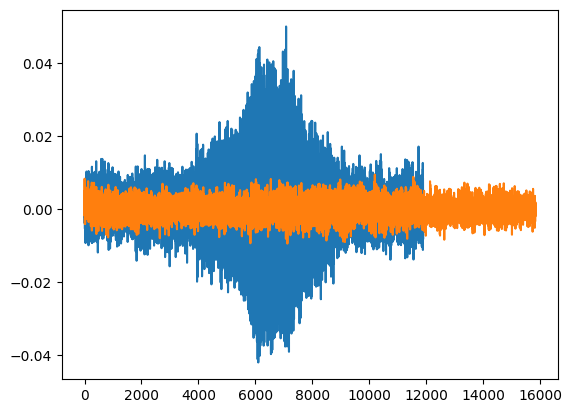

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
###CREATE THE TENSOURFOLW DATASETS
#1.define path to negative and positive path
POS = os.path.join('strong_input')
NEG = os.path.join('bgnew')

In [7]:
#2.create a tensorflow datasets
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [8]:
#3.add lables and combine the positives and negatives samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
####DEFINE AVERAGE LENGTH OF FROG CALLS TO DETERMINE THE LENGTH TO GRAB
#1.calculate the length of each files in postives samples
lengths = []
for file in os.listdir(os.path.join('strong_input')):
    tensor_wave = load_wav_48k_mono(os.path.join('strong_input', file))
    lengths.append(len(tensor_wave))

In [10]:
#2.calculate the min, max, mean
#input data length range: 0.13 - 0.407, mean=0.25 => grabe 15000)
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=11836>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=5280>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=22559>

In [13]:
####BUILD PREPROCESSING FUNCTION TO CONVERT AUDIO TO SPECTROGRAM
#1.build preprocessing function
def preprocess(file_path, label): 
    wav = load_wav_48k_mono(file_path)
    # Normalize the audio to the range [-1, 1]
    wav = wav / tf.reduce_max(tf.abs(wav))
    wav = wav[:15000]
    zero_padding = tf.zeros([15000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

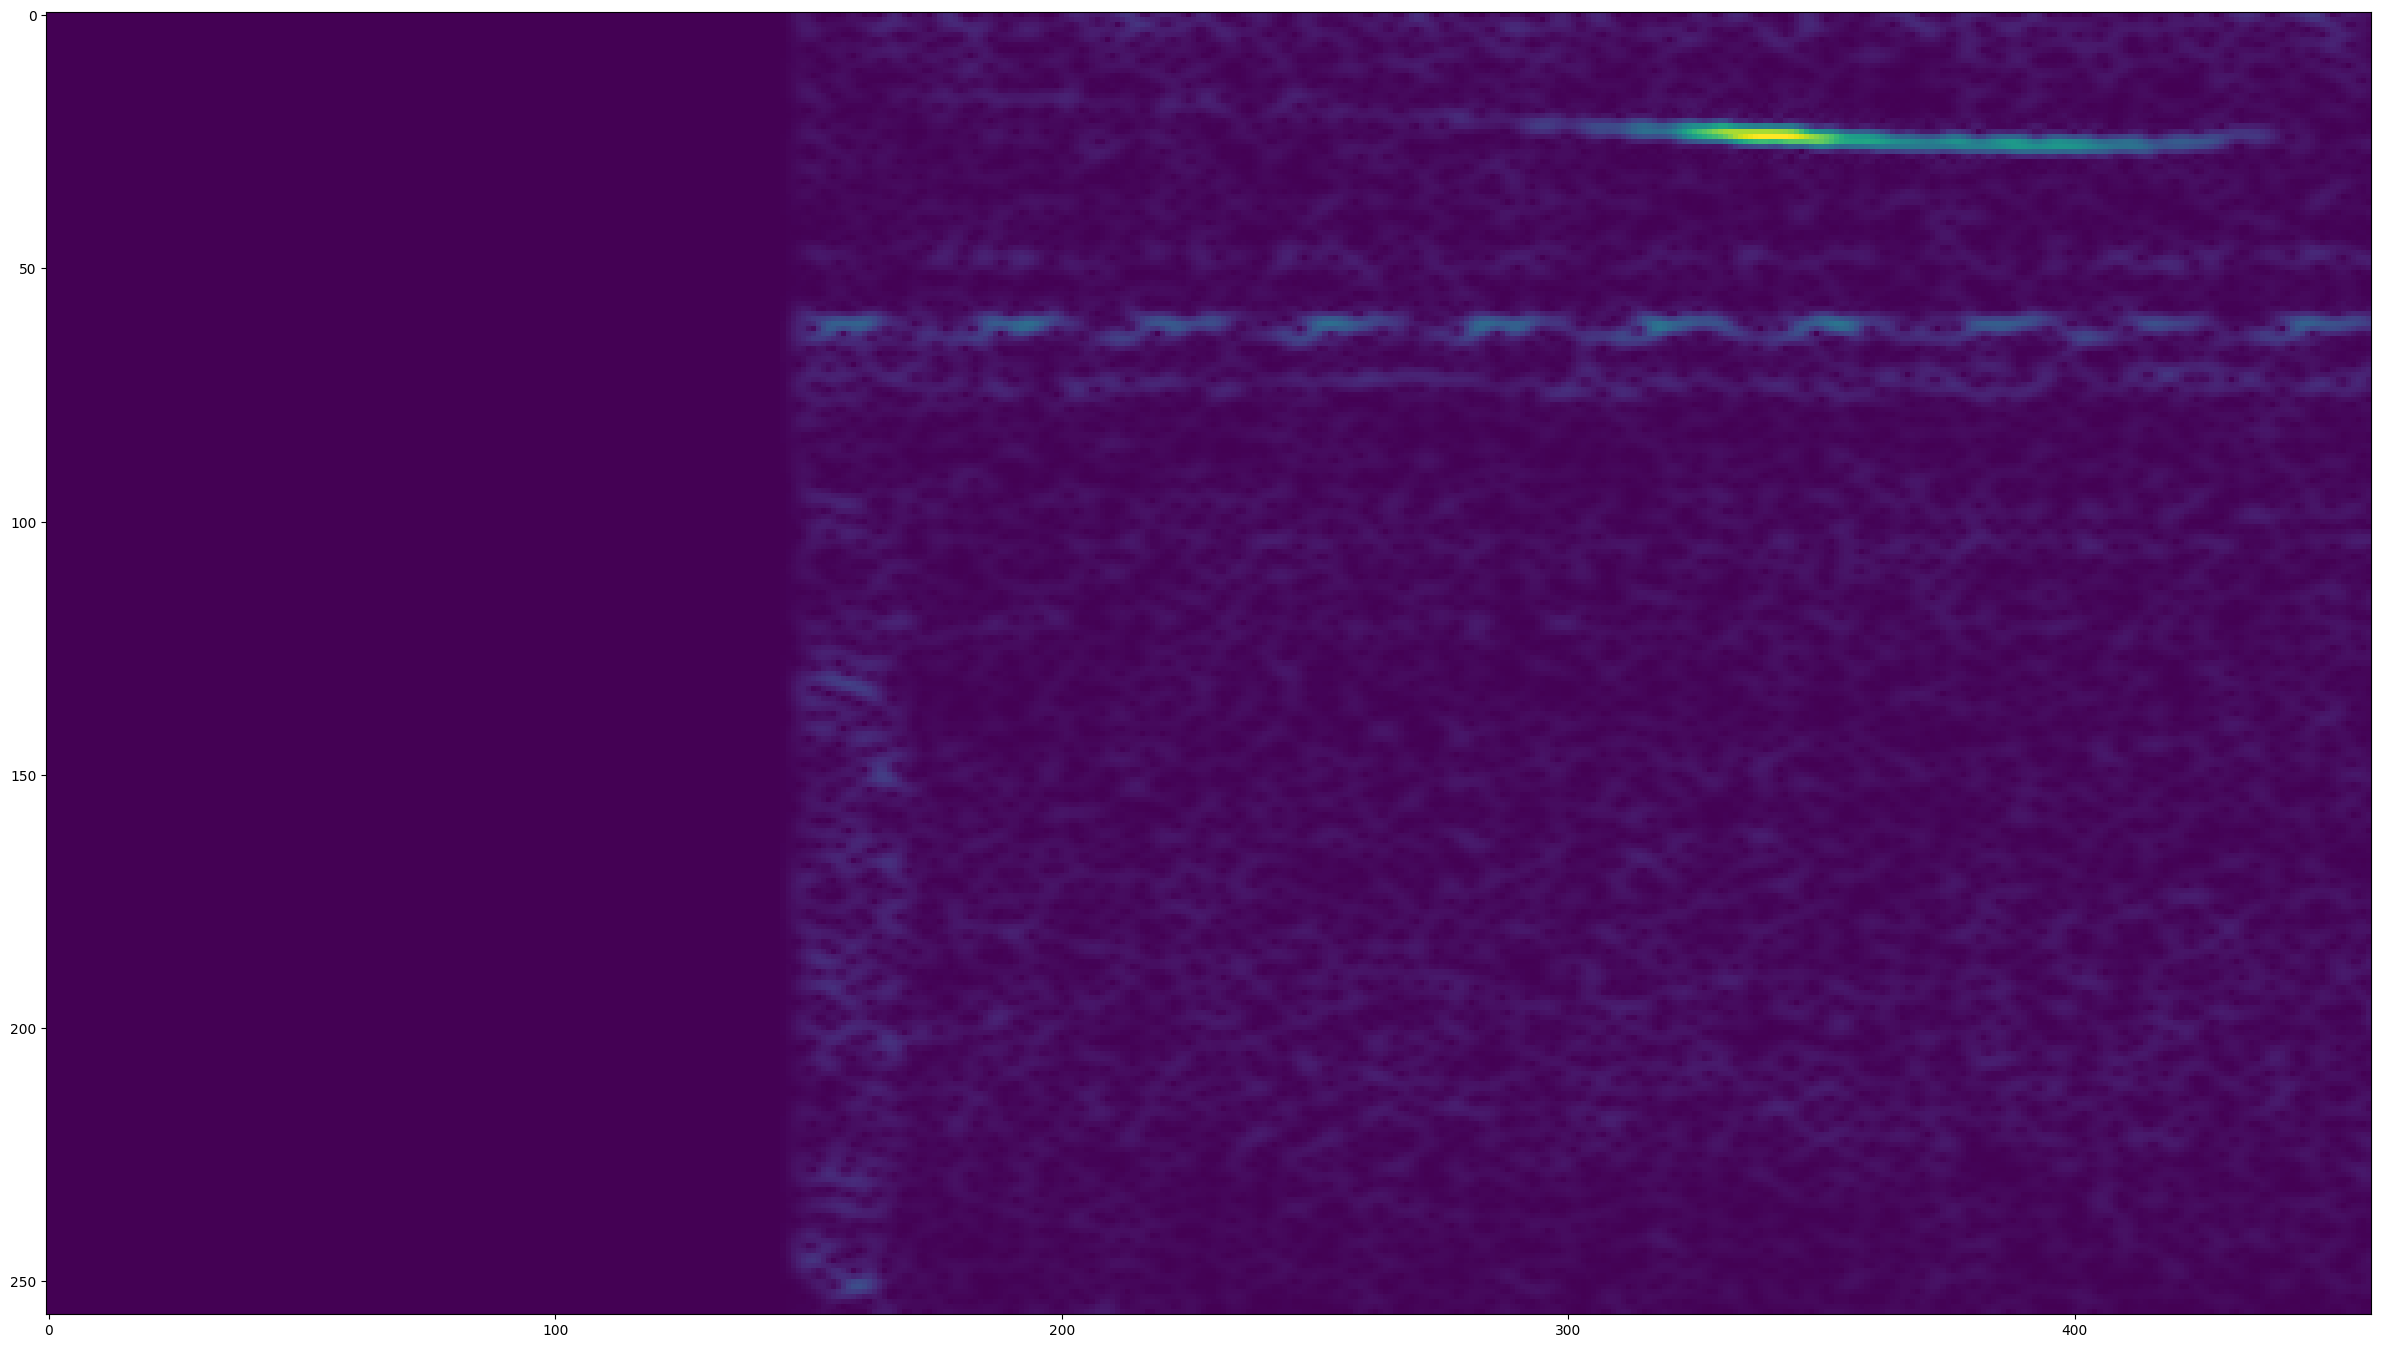

In [23]:
#2.test out the function vis spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [24]:
#####CREATE THE TRAINING AND TESTING DATA
#1.create a tensorflow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [25]:
#2.split into training and testing partitions
#data len = 81
len(data)

81

In [26]:
train = data.take(65)
test = data.skip(65).take(16)

In [27]:
#3.test one batch
# (batch_size, time_steps, frequency_bins, 1)
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 459, 257, 1)

In [29]:
####MODEL BUILDING
#1.improt packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, BatchNormalization, GlobalAveragePooling1D, Input, Dropout, MaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.utils import register_keras_serializable

In [32]:
model = Sequential()
model.add(Input(shape=(459, 257)))  
model.add(Conv1D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
model.add(BatchNormalization())
model.add(Dropout(0.5))  
model.add(Conv1D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  
model.add(MaxPooling1D(2))  
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='sigmoid'))  

In [ ]:
# Compile the model
model.compile(optimizer='Adam', 
              loss='BinaryCrossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [38]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 457, 8)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 457, 8)              │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 228, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 228, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 6,513 (25.44 KB)

 Non-trainable params: 16 (64.00 B)

In [39]:
# train the model - 30 epchos
hist = model.fit(train, epochs=30, validation_data=test)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_metric: 0.0184 - loss: 0.6521 - precision: 0.6676 - recall: 0.8606 - val_f1_metric: 0.2474 - val_loss: 0.3895 - val_precision: 0.8058 - val_recall: 0.9256
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - f1_metric: 0.1778 - loss: 0.4021 - precision: 0.8001 - recall: 0.9321 - val_f1_metric: 0.2926 - val_loss: 0.3122 - val_precision: 0.7677 - val_recall: 0.9754
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - f1_metric: 0.2523 - loss: 0.3066 - precision: 0.8014 - recall: 0.9598 - val_f1_metric: 0.2708 - val_loss: 0.2989 - val_precision: 0.7190 - val_recall: 0.9735
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - f1_metric: 0.2824 - loss: 0.2658 - precision: 0.8535 - recall: 0.9467 - val_f1_metric: 0.2912 - val_loss: 0.2850 - val_precision: 0.7067 - val_recall: 0.9815
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - f1_metric: 0.3146 - loss: 0.2185 - precision: 0.8993 - recall: 0.9288 - val_f1_metric: 0.2792 - val_los

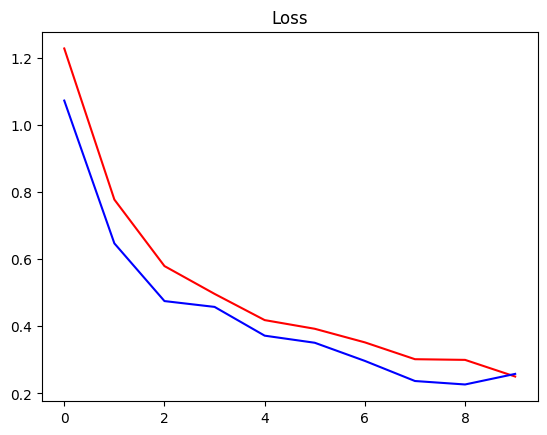

In [140]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

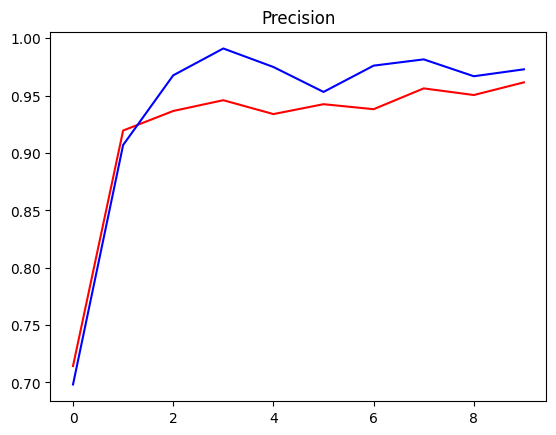

In [141]:
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
plt.plot(hist.history['val_precision_2'], 'b')
plt.show()

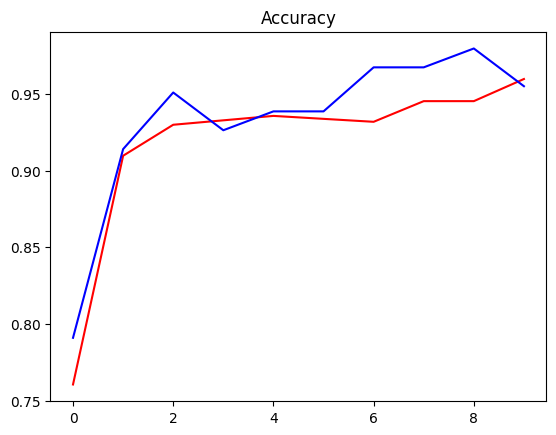

In [142]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

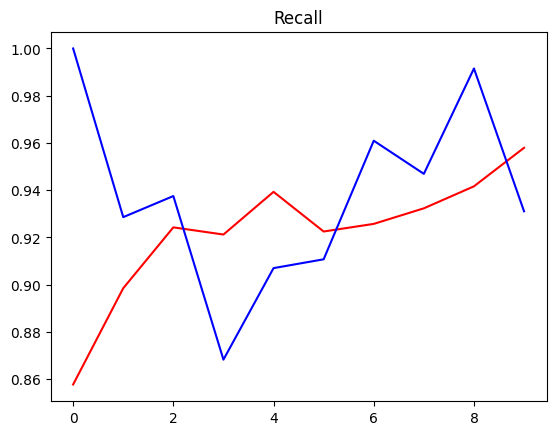

In [143]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'b')
plt.show()

In [145]:
#stroung input model
model.save('strong_input.keras')

In [69]:
#1.get the batch and prediction 
X_test, y_test = test.as_numpy_iterator().next()

In [70]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


In [71]:
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]

In [72]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=10>

In [73]:
#real data from testing partitions
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>